# 150 x 150 image net

In [1]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')


from random import shuffle
from pathlib import Path
from typing import Callable, Optional
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Resize
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.backends.mps.is_available()

True

In [4]:
class DogsCatsDataset(Dataset):
    def __init__(self,
        image_path: str,
        transform = None,
        target_transform = None,
        train = True
    ):
        random.seed(42)
        self.transform = transform
        self.target_transform = target_transform
        self.image_path = Path(image_path)
        self.pattern = '*.jpg'
        self.pt_cat = self.image_path / 'Cat'
        self.pt_dog = self.image_path / 'Dog'
        self.pt_cat_glob = self.pt_cat.glob(self.pattern)
        self.pt_dog_glob = self.pt_dog.glob(self.pattern)
        self.cat_list = list(self.pt_cat_glob)
        self.dog_list = list(self.pt_dog_glob)
        shuffle(self.cat_list)
        shuffle(self.dog_list)
        self.len_cat = int(0.8*len(self.cat_list))
        self.len_dog = int(0.8*len(self.dog_list))
        if train:
            self.image_list = self.cat_list[:self.len_cat] + self.dog_list[:self.len_dog]
        else:
            self.image_list = self.cat_list[self.len_cat:] + self.dog_list[self.len_dog:]
        
    def __len__(self):
        # pt_cat = self.image_path / 'Cat'
        # pt_dog = self.image_path / 'Dog'
        # len_ = len(list(pt_dog.glob('*'))) + len(list(pt_cat.glob('*')))
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image = PIL.Image.open(str(self.image_list[idx])).convert('RGB')
        label = int(idx >= self.len_cat)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
train_data = DogsCatsDataset(
    image_path='data/kagglecatsanddogs_5340/PetImages',
    transform=Compose([ToTensor(), Resize([150, 150])])
)
test_data = DogsCatsDataset(
    image_path='data/kagglecatsanddogs_5340/PetImages',
    transform=Compose([ToTensor(), Resize([150, 150])]),
    train=False
)

In [ ]:
def image_acc(net, loader):
    total = 0
    correct = 0
    net.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        for data in tqdm(loader):
            images, labels = data
            # print(output.shape, labels.shape)
            output = net(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    net.train()
    # print(total)
    return 100*correct/total

In [68]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*34*34, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 8)
        self.fc5 = nn.Linear(8, 2)
        self.dropout_hard = nn.Dropout(0.5)
        self.dropout_light = nn.Dropout(0.1)
        
    def forward(self, x): # bs 3 150 150
        
        x = self.pool(F.relu(self.conv1(x))) # bs 6 73 73
        x = self.dropout_light(x)
        
        x = self.pool(F.relu(self.conv2(x))) # bs 16 34 34
        x = self.dropout_light(x)
        
        x = torch.flatten(x, 1) # bs*16*34*34
        
        x = F.relu(self.fc1(x)) # bs*1024
        x = self.dropout_light(x)
        
        x = F.relu(self.fc2(x)) # bs*256
        x = self.dropout_hard(x)
        
        x = F.relu(self.fc3(x)) # bs*64
        x = self.dropout_light(x)
        
        x = F.relu(self.fc4(x)) # bs*8
        x = self.dropout_hard(x)
        
        x = self.fc5(x) # bs*2
        return x

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    device = torch.device("cpu")
    print ("MPS device not found.")
    

net = Net()
net = net.to(device)

tensor([1.], device='mps:0')


In [69]:
main_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0005)

In [70]:
bs = 32

train_loader = DataLoader(
    train_data,
    batch_size=bs,
    shuffle=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=bs,
    shuffle=True,
)

In [ ]:
epoch_weight = {}
loss_ = []

In [93]:
n_epochs = 8

for epoch in tqdm(range(n_epochs), total=n_epochs, desc='Learning'):
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}') as pbar:
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            
            optimizer.zero_grad()

            outputs = net(images.to(device))
            
            loss = main_loss(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(loss=format(float(loss), '.6f'), refresh=True)
            pbar.update()
            loss_.append(loss)
            
    epoch_weight[f'{epoch+1}'] = net.state_dict()
        

Learning:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x17eb7c340>,
 [Text(0, 0, 'Epoch 1'),
  Text(625, 0, 'Epoch 2'),
  Text(1250, 0, 'Epoch 3'),
  Text(1875, 0, 'Epoch 4'),
  Text(2500, 0, 'Epoch 5'),
  Text(3125, 0, 'Epoch 6'),
  Text(3750, 0, 'Epoch 7'),
  Text(4375, 0, 'Epoch 8'),
  Text(5000, 0, 'Epoch 9'),
  Text(5625, 0, 'Epoch 10'),
  Text(6250, 0, 'Epoch 11'),
  Text(6875, 0, 'Epoch 12'),
  Text(7500, 0, 'Epoch 13'),
  Text(8125, 0, 'Epoch 14'),
  Text(8750, 0, 'Epoch 15'),
  Text(9375, 0, 'Epoch 16'),
  Text(10000, 0, 'Finish')])

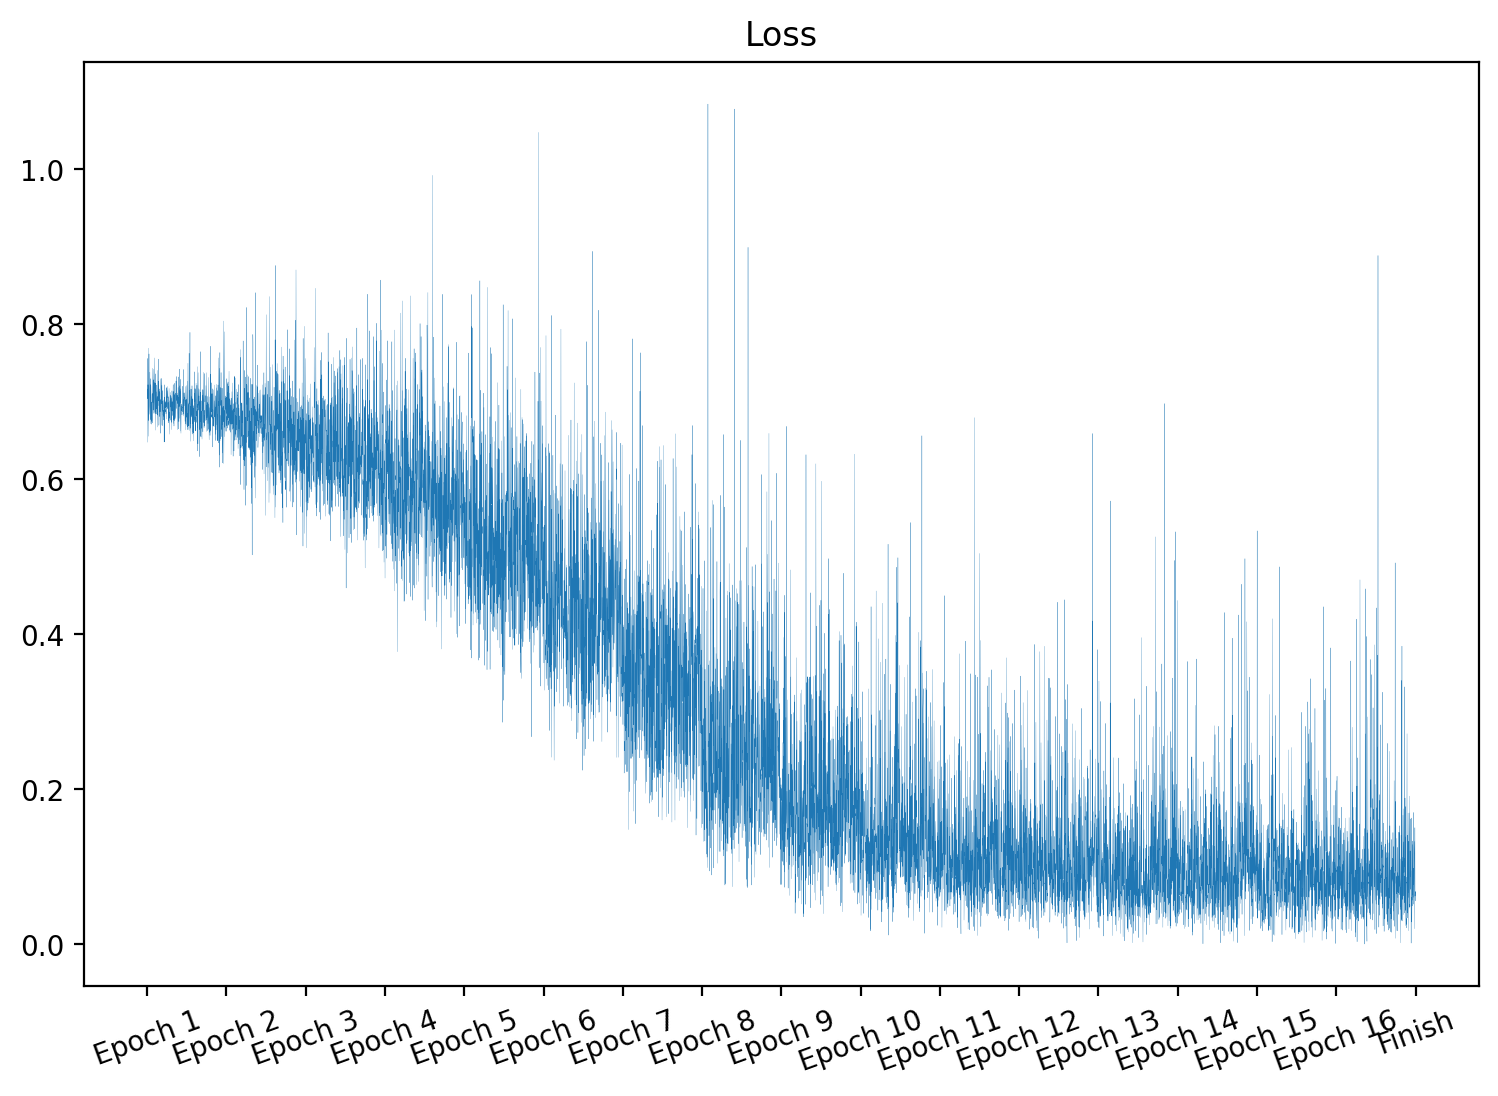

In [99]:
plt.figure(dpi=200, figsize=(9, 6))
plt.title('Loss')
plt.plot(range(len(loss_)), [x.cpu().detach() for x in loss_], linewidth=0.1)
plt.xticks(range(0, len(loss_)+1, 625), [f'Epoch {x+1}' for x in range(len(loss_)//625)]+['Finish'], rotation=20)

In [95]:
print(image_acc(net, test_loader))

  0%|          | 0/157 [00:00<?, ?it/s]

50.62


In [96]:
print(image_acc(net, train_loader))

  0%|          | 0/625 [00:00<?, ?it/s]

99.72497249724972


In [ ]:
help(net)

In [ ]:
epoch_weight['2']

In [110]:
PATH = './netnepoch.pth'
torch.save(epoch_weight['8'], PATH)

In [111]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [112]:
print(image_acc(net, test_loader))

  0%|          | 0/157 [00:00<?, ?it/s]

50.62


In [ ]:
print(image_acc(net, train_loader))

In [ ]:
epoch_weight['1']

In [ ]:
epoch_weight['2']